# Home Assignment No. 3: Practice

In [120]:
import numpy as np
import pandas as pd

# for reproducibility
np.random.seed(0)

## Task 1. Feature Engineering and Bagging Ensembles of Regressors [8 points]

In this problem, you are to deal with [Student Stress Factors: A Comprehensive Analysis](https://www.kaggle.com/datasets/rxnach/student-stress-factors-a-comprehensive-analysis/) dataset.

Your goal will be to determine the optimal parameters for two Bagging-Based Forest Ensemble **Classifiers** and compare the forests.

In [121]:
from sklearn.model_selection import train_test_split

## Task 1.1. Feature Engineering [4 points]
We are going to use the 'depression' as our target variable. Since the values of this feature are between 0 and 27, we'll convert it into binary variable by thresholding. We'll classify students with 'depression' higher than 13 as depressed (1) and students with 'depression' lower or equal to 13 as not depressed (0)

In [122]:
# Data loading
data = pd.read_csv('data/StressLevelDataset.csv').dropna()

# Convert to depressed (1) or not depressed (0)
data.depression = (data.depression > 13).astype(int)

# Convert entries to float numbers
data = data.astype(np.float32)

# Drop depression information in X
X = data.drop('depression', axis=1)

# Assign depression information to labels vector
y = data.depression

# Do traina nd test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Take a glance at the data
data.sample(3).sort_index()

anxiety_level  self_esteem  mental_health_history  depression  headache  \
395            5.0         25.0                    0.0         0.0       1.0   
477           17.0         12.0                    1.0         1.0       4.0   
860           10.0         15.0                    1.0         0.0       3.0   

     blood_pressure  sleep_quality  breathing_problem  noise_level  \
395             2.0            5.0                1.0          1.0   
477             3.0            1.0                4.0          4.0   
860             1.0            3.0                2.0          2.0   

     living_conditions  ...  basic_needs  academic_performance  study_load  \
395                3.0  ...          4.0                   4.0         1.0   
477                2.0  ...          1.0                   2.0         3.0   
860                3.0  ...          3.0                   3.0         3.0   

     teacher_student_relationship  future_career_concerns  social_support  \
395                           4.0                     1.0             3.0   
477                           1.0                     5.0             1.0   
860                           2.0                     2.0             2.0   

     peer_pressure  extracurricular_activities  bullying  stress_level  
395            1.0                         1.0       1.0           0.0  
477            4.0                         4.0       4.0           2.0  
860            2.0                         3.0       2.0           1.0  

[3 rows x 21 columns]

## Task 1.2. Bagging Ensembles of Classifiers [4 points]

In this problem, you are going to compare different `RandomForestClassifier` and `ExtraTreesClassifier` models to predict a binary variable based on their **accuracy** in the test set. 

[Extremely Randomized Forest](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.65.7485&rep=rep1&type=pdf) is another bootstraped forest with a simple tree building algorithm. Each tree node split is chosen at random w.r.t. both feature and threshold (while in random forests the split minimizes impurity).

You have to do the following steps:

1. For both Forests perform the [**Grid Search**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) (on the train data) over the most important algorithm's parameters.

2. For the optimal parameters report the train, validation, and test scores. Note that ´RandomForestClassifier´ and ´ExtraTreesClassifier´ has a score function to calculate the coefficient of determination score for a given dataset. You may use this one to compute scores.

Decision Trees algorithms contain many heuristics. Most heuristics map well to objectives:

* **Splitting** by information gain $\rightarrow$ training loss

* **Pruning**  $\rightarrow$ regularization defined by the number of nodes

* **Maximum depth** $\rightarrow$ constraint on the function space

* **The minimum number of samples** required to be at a **leaf node** $\rightarrow$ smoothing the model, especially in regression

So, we will tune the following hyper-parameters: `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`.


The Extra-(Randomized)-Trees might be a bit worse than Random Forests when there are many noisy features. From the article [Extremely Randomized Forest](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.65.7485&rep=rep1&type=pdf): 
> The analysis of the algorithm and the determination of the optimal value of K on several test problem variants have shown that the value is in principle dependent on problem specifics, in particular the proportion of irrelevant attributes. [...] The bias/variance analysis has shown that Extra-Trees work by decreasing variance while at the same time increasing bias. [...] _When the randomization increases above the optimal level, variance decreases slightly, while bias increases often significantly_.

In [123]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [124]:
def hyper_parameters_tuning(X_train, y_train, X_test, y_test, classifier, parameters, scoring, cv):
    """
    Fine tunes a given classifier over parameters using scoring and cv.

    Args:
        X_train: Training data in matrix form
        y_train: Labels for training data
        X_test: Testing data in matrix form
        y_test: Labels for testing data
        classifier: Model to do cross validation on
        parameters: Parameters to optimize
        scoring: Scoring function for model
        cv: Number for k-fold cross validation; if None, default is 5-fold cross validation

    Returns:
        Prints best parameters aswell as train, validation and test scores
    """
    # Print classifier, for which a grid search is carried out
    print(f'Tuning hyper-parameters for {classifier.__class__.__name__}...\n')

    # Declare grid search
    grid_search = GridSearchCV(
        estimator=classifier,
        param_grid=parameters,
        scoring=scoring,
        cv=cv
    )

    # Fit classifier using grid search
    grid_search.fit(X_train, y_train)

    # Extract best parameters and train score
    best_parameters = grid_search.best_params_
    train_score = grid_search.best_score_

    # Compute validation score
    val_score = grid_search.cv_results_['mean_test_score'][grid_search.best_index_]

    # Compute test score
    best_model = grid_search.best_estimator_
    test_score = best_model.score(X_test, y_test)

    # Best hyper-parameters
    print(f'Best hyper-parameters: {best_parameters}\n')

    # Training score
    print('Train: {:.3f}'.format(train_score))
    
    # Validation score
    print('Valid: {:.3f}'.format(val_score))
    
    # Testing score
    print('Test: {:.3f}\n'.format(test_score))

In [125]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [126]:
# Declare parameters, random_forest and extra_trees classifiers
parameters = {
    'n_estimators' : [35, 40, 45],
    'max_depth' : [1, 2, 3],
    'min_samples_split' : [5, 10, 15],
    'min_samples_leaf' : [4, 5, 6]
}

random_forest = RandomForestClassifier()
extra_trees = ExtraTreesClassifier()

# Tune hyperparameters for random forest
hyper_parameters_tuning(np.array(X_train), np.array(y_train),
                        np.array(X_test), np.array(y_test),
                        random_forest,
                        parameters,
                        scoring='accuracy', cv=5)

# Tune hyperparameters for extra random forest
hyper_parameters_tuning(np.array(X_train), np.array(y_train),
                        np.array(X_test), np.array(y_test),
                        extra_trees,
                        parameters,
                        scoring='accuracy', cv=5)

Tuning hyper-parameters for RandomForestClassifier...

Best hyper-parameters: {'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 35}

Train: 0.870
Valid: 0.870
Test: 0.876

Tuning hyper-parameters for ExtraTreesClassifier...

Best hyper-parameters: {'max_depth': 1, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 45}

Train: 0.870
Valid: 0.870
Test: 0.887



## Task 2. AdaBoost [26 points]

> Boosting Machines (BM) is a family of widely popular and effective methods for classification and regression. The main idea behind BMs is that **combining weak learners**, that perform slightly better than random, can result in **strong learning models**.

> AdaBoost utilizes the greedy training approach: first, we train the weak learners (they are later called `base_classifiers`) on the whole dataset, and in the next iterations, we train the model on the samples, on which the previous models have performed poorly. This behavior is achieved by reweighting the training samples at each step. 

#### The task:

In this exercise, you are asked to implement one of the earlier variants of BMs - **AdaBoost**, a modified version of it and compare these to the already existing `sklearn` implementation. The key steps are:

* Copy the solution from task 1.1 so that `depression` variable is binarized.  

* Complete the `ada_boost_alpha`, `ada_boost_distribution` and `ada_boost_distribution_modify` functions

* Complete the `.fit` method of `Boosting` class

* Complete the `.predict` method of `Boosting` class

##### Criteria:

The decision boundary of the final implementation should look reasonably identical to the model from `sklearn`, and should achieve accuracy close to `scikit`:
$$|\textrm{your accuracy} - \text{sklearn accuracy}| \leq 0.005 $$

In [127]:
from sklearn.datasets import make_moons

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap

In [128]:
# Data loading
data = pd.read_csv('data/StressLevelDataset.csv').dropna()

# Convert to depressed (1) or not depressed (0)
data.depression = (data.depression > 13).astype(int)

# Convert to float
data = data.astype(np.float32)

# Only use living_conditions and stress_level features
X = data[['living_conditions', 'stress_level']].to_numpy()
y = data.depression.to_numpy()

In [129]:
X.shape

(1100, 2)

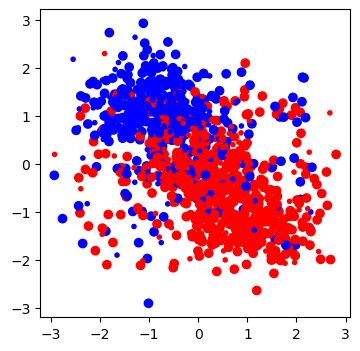

In [130]:
### plot the dataset

# X, y = make_moons(n_samples=1000, noise=0.3, random_state=0)
X = (X - np.mean(X, axis=0, keepdims=True)) / np.std(X, axis=0, keepdims=True)
X += 0.5 * np.random.randn(*X.shape) 
# for convenience convert labels from {0, 1} to {-1, 1}
y[y == 0] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 30),
                     np.linspace(y_min, y_max, 30))

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

plt.figure(figsize=(4, 4))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
plt.scatter(X_test[:, 0], X_test[:, 1], marker='.', c=y_test, cmap=cm_bright)
plt.show()

**Base classifier**

In [131]:
from sklearn.tree import DecisionTreeClassifier

* `ada_boost_alpha` - function, which calculates the weights of the linear combination of the classifiers

* `ada_boost_distribution` - function, which calculates sample weights

* `ada_boost_distribution` - a modified function, which calculates sample weights

In [132]:
def ada_boost_alpha(y, y_pred_k, distribution):
    """
    Calculates the weight of the k'th classifier.

    Args:
        y: Labels
        y_pred_k: Labels predicted by the k'th classifier
        distribution: Weights distribution for the samples

    Returns:
        alpha: Weight of the k'th classifier
    """
    # Calculate weighted error
    weighted_err = np.sum(distribution * (y != y_pred_k)) / np.sum(distribution)

    # Calculate alpha
    if weighted_err == 0: # Expression in log goes to infinity
        alpha = np.inf
    elif weighted_err == 1: # Expression in log goes to zero
        alpha = -np.inf
    else: # Expression in log is between zero and infinity
        alpha = np.log((1 - weighted_err) / weighted_err)

    # Return weight of k'th classifier
    return alpha

In [133]:
def ada_boost_distribution(y, y_pred_k, distribution, alpha_k):
    """
    Calculates new weights of the k'th classifier for the AdaBoost algorithm.

    Args:
        y: Labels
        y_pred_k: Labels predicted by the k'th classifier
        distribution: Weights distribution for the samples
        alpha_k: Weight of the k'th classifier

    Returns:
        distribution: Updated weights distribution for the samples
    """
    # Update weights distribution
    distribution = distribution * np.exp(alpha_k * (y != y_pred_k))

    # Return weights distribution
    return distribution

* Now modify the `ada_boost_distribution` function so that the expression `y * y_pred_k` will be scaled between `-2t+1` and 1 for a t value which should be equal to `0.5`. After that, we'll also use a version of adaboost using this distrbution along with the original one. Hint: `y * y_pred_k` is equal to either -1 or 1.

In [134]:
def ada_boost_distribution_modify(y, y_pred_k, distribution, alpha_k, t=0.5):
    """
    Calculates new weights of the k'th classifier for the AdaBoost algorithm with modified scaling.

    Args:
        y: Labels
        y_pred_k: Labels predicted by the k'th classifier
        distribution: Weights distribution for the samples
        alpha_k: Weight of the k'th classifier
        t: Scaling factor, default is 0.5

    Returns:
        distribution: Updated weights distribution for the samples
    """
    # Update weights distribution
    distribution = distribution * np.exp(alpha_k * np.where(y * y_pred_k != -1, -2 * t + 1, 1))

    # Return weights distribution
    return distribution

In [135]:
class AdaBoost(object):
    """
    Generic class for construction of boosting models.
    
    Args:
        n_estimators: Int, number of estimators (number of boosting rounds)
        base_classifier: Callable, a function that creates a weak estimator. Weak estimator should support sample_weight argument
        get_alpha: Callable, a function, that calculates new alpha given current distribution, prediction of the t-th base estimator,
                            boosting prediction at step (t-1) and actual labels
        get_distribution: Callable, a function, that calculates samples weights given current distribution, prediction, alphas and actual labels
        X: Matrix containing feature vectors as rows
        y: Labels associated to feature vectors

    Returns:
        predict: Method to compute prediction using the aggregated method
    """
    def __init__(self,
                 base_classifier=None,
                 n_estimators=50,
                 get_alpha=ada_boost_alpha,
                 update_distribution=ada_boost_distribution):
        # Initialize parameters and make them accessible for other methods
        self.n_estimators = n_estimators
        self.base_classifier = base_classifier
        self.get_alpha = get_alpha
        self.update_distribution = update_distribution
        
    def fit(self, X, y):
        # Instantiate variables for further use in the method
        n_samples = len(X)
        distribution = np.ones(n_samples, dtype=float) / n_samples
        self.classifiers = []
        self.alphas = []

        # Loop over number of estimators
        for i in range(self.n_estimators):
            # Create a new classifier
            self.classifiers.append(self.base_classifier())     
            self.classifiers[-1].fit(X, y, sample_weight=distribution)

            # Make prediction
            y_pred_k = self.classifiers[-1].predict(X)

            # Calculate alpha and append new alpha to self.alphas
            self.alphas.append(self.get_alpha(y, y_pred_k, distribution))

            # Update distribution and normalize it
            distribution = self.update_distribution(y, y_pred_k, distribution, self.alphas[-1])
            distribution = distribution / np.sum(distribution)
    
    def predict(self, X):
        # Initialize final predictions
        final_predictions = np.zeros(X.shape[0])
        
        # Get the weighted votes of the classifiers
        for alpha, classifier in zip(self.alphas, self.classifiers):
            final_predictions = final_predictions + alpha * classifier.predict(X)
        
        # Take the sign of the weighted sum
        final_predictions = np.sign(final_predictions)

        return final_predictions

In [136]:
from sklearn.ensemble import AdaBoostClassifier

In [137]:
# Declare estimators
n_estimators = 100
max_depth = 5

# Declare sklearn classifier
ada_boost_sklearn = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth),
                                       algorithm="SAMME",
                                       n_estimators=n_estimators)

# Fit sklearn classifier
ada_boost_sklearn.fit(X_train, y_train)

# Declare Adaboost classifier
ada_boost = AdaBoost(base_classifier=lambda: DecisionTreeClassifier(max_depth=max_depth),
                     n_estimators=n_estimators,
                     get_alpha=ada_boost_alpha,
                     update_distribution=ada_boost_distribution)

# Fit Adaboost classifier
ada_boost.fit(X_train, y_train)

# Declare modified Adaboost classifier
ada_boost_mod = AdaBoost(base_classifier=lambda: DecisionTreeClassifier(max_depth=max_depth),
                     n_estimators=n_estimators,
                     get_alpha=ada_boost_alpha,
                     update_distribution=ada_boost_distribution_modify)

# Fit modified Adaboost classifier
ada_boost_mod.fit(X_train, y_train)

In [138]:
classifiers = [ada_boost_sklearn, ada_boost, ada_boost_mod]
names = ['ada_boost_sklearn', 'ada_boost', 'ada_boost_mod']

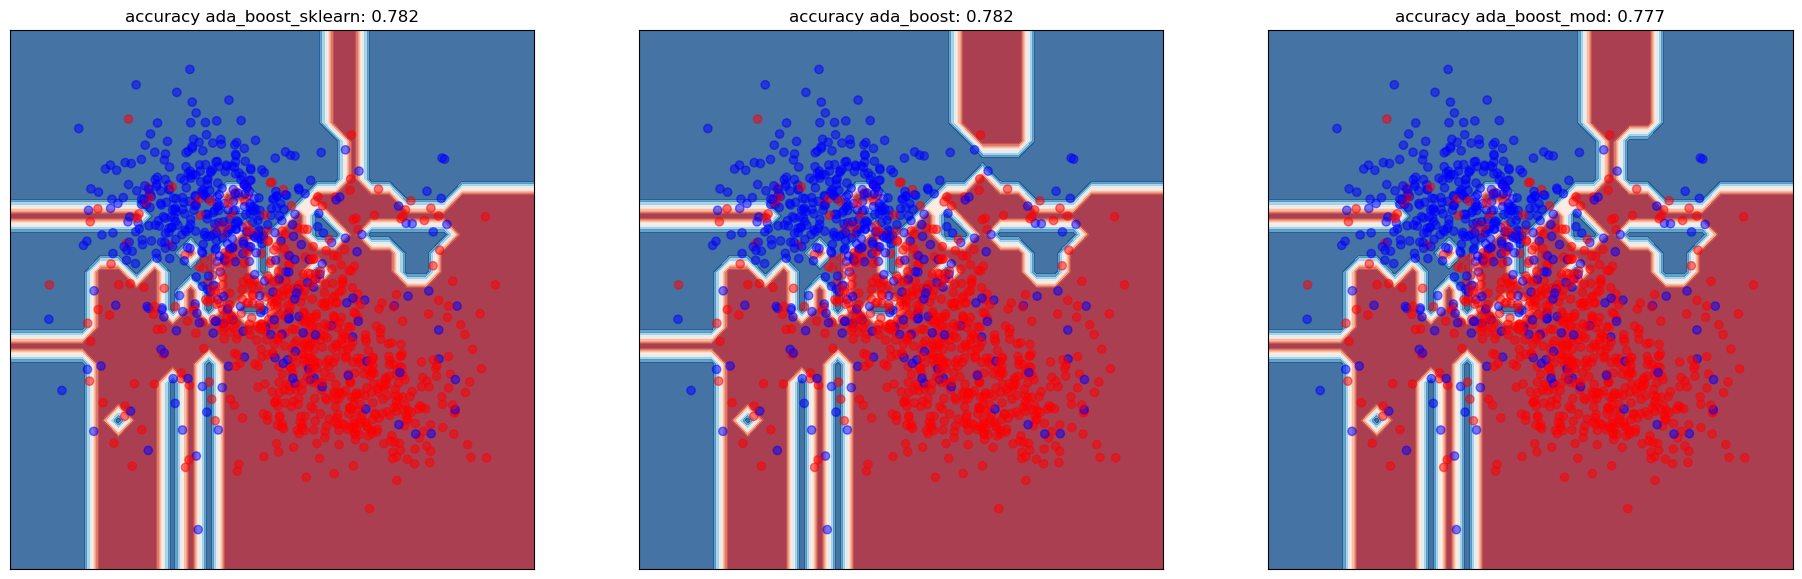

In [139]:
# test ensemble classifier

plt.figure(figsize=(23, 7))

for i, classifier in enumerate(classifiers):
    prediction = classifier.predict(X_test)

    # put the result into a color plot
    
    ax = plt.subplot(1, len(classifiers), i + 1)
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, alpha=0.5)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title('accuracy {}: {:.3f}'.format(names[i], (prediction == y_test).sum() * 1. / len(y_test)))

## Task 3. Gradient Boosting and Feature Selection [15 points]

**Gradient Boosting Machines** (GBM) are historical and logical continuations of the first boosting algorithms. In a way, one can consider AdaBoost as another variant of GBMs. These are effective tools widely used in industry, research, and various machine learning competitions. 

In this task, we offer to focus on one variant of GBM called [**XGBoost**](https://github.com/dmlc/xgboost/tree/master/python-package). The dataset that is going to be used is   [Titanic - Machine Learning from Disaster](https://www.kaggle.com/c/titanic).

You will need to construct an **XGBoost** classification model, train it, measure the training time and compare it to **Random Forest**. Afterward, compare the models' feature importances.

**The task:**

* Copy the the solution from task 1.1 so that `depression` variable is binarized.  

* Train the XGBoost classifier on the provided dataset

  * Measure the training time
  
  * Measure the precision/recall on the test set

* Train Random Forest classifier and compare it to XGBoost

* Compare the feature importances of the trained XGBoost and Random Forest Classifiers. Why do you think they are different? Explain.

**HINT**: in order to measure the training time you can use [**timeit** cell magic](http://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit) or [**time**](https://docs.python.org/3/library/time.html) library.

In [140]:
from xgboost import XGBClassifier

In [141]:
# Data loading
data = pd.read_csv('data/StressLevelDataset.csv').dropna()

# Convert to depressed (1) or not depressed (0)
data.depression = (data.depression > 13).astype(int)

# Convert entries to float numbers
data = data.astype(np.float32)

# Drop depression information in X
X = data.drop('depression', axis=1)
cols = list(X)

# Assign depression information to labels vector
y = data.depression

# Do traina nd test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [142]:
from time import time
from sklearn.metrics import average_precision_score
from sklearn.ensemble import RandomForestClassifier

Implement and fit XGBClassifier and measure the convergence time

In [143]:
# Declare and fit xgb classifier
xgb_clf = XGBClassifier(n_estimators=100, random_state=0)
start_t = time()
xgb_clf.fit(X_train, y_train)
training_t_clf = time() - start_t

# Print training time
print(f'Training time of xgb classifier: {training_t_clf:.3f} seconds')

# Measure precision/recall and print results
precision_xgb = average_precision_score(y_test, xgb_clf.predict(X_test))

# Print precision
print(f'Precision of xgb classifier: {precision_xgb:.3f}')

Training time of xgb classifier: 0.084 seconds
Precision of xgb classifier: 0.722


Implement and fit RandomForestClassifier and measure the convergence time

In [144]:
# Declare and fit random forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
start_t = time()
rf_clf.fit(X_train, y_train)
training_t_rf = time() - start_t

# Print training time
print(f'Training time of rf classifier: {training_t_rf:.3f} seconds')

# Measure precision/recall and print results
precision_rf = average_precision_score(y_test, rf_clf.predict(X_test))

# Print precision
print(f'Precision of xgb classifier: {precision_rf:.3f}')

Training time of rf classifier: 0.138 seconds
Precision of xgb classifier: 0.738


In [145]:
len(cols)

20

Time to display the importance of the weights for XGBClassifier and RandomForestClassifier and compare them

In [146]:
from IPython.display import display

def highlight_zeros(s):
    is_max = s == 0
    
    return ['background-color: yellow' if v else '' for v in is_max]

display(pd.DataFrame(np.vstack((xgb_clf.feature_importances_*100, rf_clf.feature_importances_*100, xgb_clf.feature_importances_ / rf_clf.feature_importances_)),
                     index=['XGB Classifier', 'RF Classifier', 'Relative Importance XGB/RF'],
                     columns=cols).style.apply(highlight_zeros))

In [147]:
# Sort the feature importances for XGBoost in descending order
sorted_idx_xgb = np.argsort(xgb_clf.feature_importances_)[::-1]
xgb_imp_sorted = xgb_clf.feature_importances_[sorted_idx_xgb]
xgb_lb_sorted = np.array(cols)[sorted_idx_xgb]

# Sort the feature importances for Random Forest in descending order
sorted_idx_rf = np.argsort(rf_clf.feature_importances_)[::-1]
rf_imp_sorted = rf_clf.feature_importances_[sorted_idx_rf]
rf_lb_sorted = np.array(cols)[sorted_idx_rf]

# Create a DataFrame with 4 columns: XGB labels, XGB importances, RF labels, RF importances
combined_importance_df = pd.DataFrame({
    'XGB Feature': xgb_lb_sorted,
    'XGB Importance': xgb_imp_sorted,
    'RF Feature': rf_lb_sorted,
    'RF Importance': rf_imp_sorted
})

# Display the result
display(combined_importance_df)

XGB Feature  XGB Importance  \
0                   stress_level        0.662131   
1                 blood_pressure        0.091053   
2                     study_load        0.033619   
3   teacher_student_relationship        0.018970   
4                 social_support        0.018881   
5                    basic_needs        0.016635   
6                       headache        0.015692   
7          mental_health_history        0.014577   
8         future_career_concerns        0.014382   
9              living_conditions        0.014209   
10                   noise_level        0.012906   
11                      bullying        0.012307   
12                   self_esteem        0.011361   
13                 anxiety_level        0.010582   
14          academic_performance        0.010496   
15                 peer_pressure        0.009829   
16             breathing_problem        0.009113   
17                        safety        0.009056   
18                 sleep_quality        0.007867   
19    extracurricular_activities        0.006333   

                      RF Feature  RF Importance  
0                   stress_level       0.102453  
1                       bullying       0.100837  
2                  sleep_quality       0.100230  
3         future_career_concerns       0.079073  
4                  anxiety_level       0.072399  
5                 blood_pressure       0.068977  
6                    self_esteem       0.061333  
7                 social_support       0.060406  
8     extracurricular_activities       0.059399  
9                  peer_pressure       0.057753  
10                      headache       0.032854  
11  teacher_student_relationship       0.028527  
12                    study_load       0.025454  
13                   basic_needs       0.024115  
14             breathing_problem       0.022296  
15             living_conditions       0.021888  
16                        safety       0.021234  
17                   noise_level       0.020861  
18          academic_performance       0.020520  
19         mental_health_history       0.019392

**Are the feature importances calculated by the previously trained XGBoost and Random Forest Classifiers different or the same, why?**

As one can observe from the above results, the feature importances as calculated by XGBoost and random forest are quite different in their magnitude. However, they do agree on which feature is most important for the classification, if an individual is depressed or not: The `stress-level` feature. The RF algorithm nevertheless predicts the `bullying` feature almost as imortant as `stress_level`. As a general observation, we can see that the RF algorithm tends to distribute importance more evenly over the feature, whereas the XGB algorithm tends to allocate more importance to only certain features.

The underlying reason for this observation is that the XGB algorithm is a boosting algorithm, whereas RF is of a bagging algorithm nature. Boosting algorithms iterate the weights attributed to misclassified samples for each iteration step, whereas bagging algorithms just use subsets of the training data to train independent classifiers, which are in the end averaged. As a result, boosting algorithms give more importance to those features, which are important to decide on often misclassified samples. Bagging algorithms however tend to distribute the importance over the features more evenly, because each classifier is trained independently of the other classifiers; as a result of this, one classifier could give more importance to feature $x_i$ than to feature $x_j$, but another classifier in the ensemble gives more weight to feature $x_j$ as to $x_i$; thus, the averaging over all classifiers in the ensemble in the end smoothes out spikes in feature importance.

## Task 4. $\color{red}{\text{(Bonus)}}$. KMeans and Gaussian Mixture Algorithms [8 + 8 = 16 points]

Explore **KMeans** and **Gaussian Mixture** clustering algorithms from `sklearn`.

To evaluate the performance, use **two** metrics: `silhouette score` and `mutual information`

## Task 4.1. $\color{red}{\text{(Bonus)}}$. Grid Search [8 points]

For each algorithm **your task** is to find the parameters leading to the best performance for `n_gaussians=true_number_of_clusters`.

Apply the algorithm with the best parameters with the true number of clusters and at least two **other settings** for the number of clusters: a smaller and a larger number than the true one.

**NOTE:** `sklearn.model_selection.GridSearchCV` does not support clustering methods. Hence you are supposed to do it manually.

In [148]:
import matplotlib.cm as cm
from sklearn import datasets

True number of clusters is 15


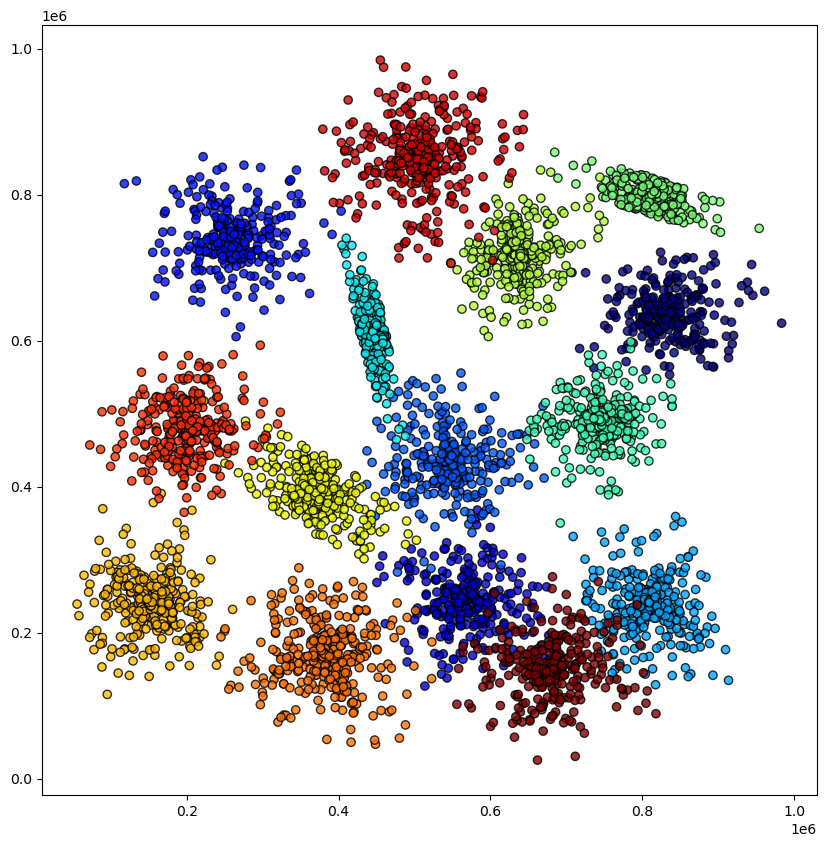

In [149]:
points, labels = np.loadtxt('data/clustering.txt'), np.loadtxt('data/clustering_labels.txt')
labels = labels.astype(int)
print("True number of clusters is {}".format(np.max(labels)))

plt.figure(figsize=(10, 10))
plt.scatter(points[:, 0], points[:, 1], c=labels, cmap=cm.jet, alpha=0.8, edgecolor='k')

plt.show()

In [150]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score, mutual_info_score

In [151]:
def grid_search(clasterizator, param_grid, metric, points, labels):
    """
    Performs a grid search for a given clasterizator.

    Args:
        clasterizator: Callable, a clustering algorithm like k-means, for example
        param_grid: Dictionary of parameters
        metric: Callable, a metric like silhouette_score or mutual_info_score, for example
        points: Matrix of training points
        labels: Vector of class labels of the training points

    Returns:
        best_score: Best calculated score
        best_params: Parameters associated to best_score
    """
    # Initialize score and parameter storage
    best_score = -np.inf
    best_params = None

    # Interate over parameters using ParameterGrid from sklearn.model_selection
    for params in ParameterGrid(param_grid):
        # Instantiate and fit model
        model = clasterizator(**params)
        model.fit(points)

        # Make predictions
        pred_labels = model.predict(points)

        # Calculate scores by means of given metrics
        if metric == 'silhouette':
            score = silhouette_score(points, pred_labels)
        elif metric == 'mutual_info':
            score = mutual_info_score(labels, pred_labels)
        else:
            print('No valid metric has been chosen; choose an appropriate metric!')

        # Check for improvement
        if score > best_score:
            best_score = score
            best_params = params
    
    # Return best score and best parameters
    return best_score, best_params

In [152]:
def print_results(clasterizator, param_grid, metrics, points, labels):
    # Define storage for best configurations
    best_configurations = []

    for metric in metrics:
        best_score, best_parameters = grid_search(clasterizator, param_grid, metric, points, labels)
        print('{} score: {:.3f} via parameters: {}'.format(metric, best_score, best_parameters))

        # Store best parameters for silhouette metric
        if metric == 'silhouette':
            best_configurations.append(best_parameters)
    print()

    # Return best configurations
    return best_configurations

In [ ]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

## Task 4.2. $\color{red}{\text{(Bonus)}}$. K-Mean and Gaussian Mixtures Algorithms [8 points]

* In this part, you are supposed to iterate over different cluster numbers, and do the grid search for each cluster number with `KMeans` and `GaussianMixture`. Moreover, print the best `silhouette` and `mutual_info` for each cluster number for `KMeans` and `GaussianMixture`.

In [155]:
# Define values to check via grid_search
n_gaussians = [10, 15, 20]
tol = [0.1, 0.01]
max_iter = [100, 200, 300]
initialization = ['k-means++', 'random']
n_init = [10, 20]
covariance_type = ['full', 'diag', 'spherical']

# Define strings for identifying the metric
scores = ['silhouette', 'mutual_info']

# Define parameter grid for KMeans clustering
param_grid_kmeans = {'tol': tol, 'max_iter': max_iter, 'init': initialization, 'n_init': n_init}
param_grid_gmm = {'tol': tol, 'max_iter': max_iter, 'covariance_type': covariance_type}

# Best configurations
best_config_dict = {}

# Iterate over cluster_numbers
for cluster_num in n_gaussians:
    print(f'Results for {cluster_num} clusters:\n')
    updated_dict_kmeans = {**param_grid_kmeans, 'n_clusters': [cluster_num]}
    updated_dict_gmm = {**param_grid_gmm, 'n_components': [cluster_num]}
    best_config_dict[str(cluster_num) + 'kmeans'] = print_results(clasterizator=KMeans, param_grid=updated_dict_kmeans, metrics=scores, points=points, labels=labels)[0]
    best_config_dict[str(cluster_num) + 'gmm'] = print_results(clasterizator=GaussianMixture, param_grid=updated_dict_gmm, metrics=scores, points=points, labels=labels)[0]

Results for 10 clusters:

silhouette score: 0.523 via parameters: {'init': 'k-means++', 'max_iter': 200, 'n_clusters': 10, 'n_init': 10, 'tol': 0.1}
mutual_info score: 2.102 via parameters: {'init': 'random', 'max_iter': 300, 'n_clusters': 10, 'n_init': 20, 'tol': 0.01}

silhouette score: 0.506 via parameters: {'covariance_type': 'full', 'max_iter': 300, 'n_components': 10, 'tol': 0.1}
mutual_info score: 2.136 via parameters: {'covariance_type': 'full', 'max_iter': 100, 'n_components': 10, 'tol': 0.1}

Results for 15 clusters:

silhouette score: 0.626 via parameters: {'init': 'k-means++', 'max_iter': 300, 'n_clusters': 15, 'n_init': 20, 'tol': 0.1}
mutual_info score: 2.563 via parameters: {'init': 'random', 'max_iter': 200, 'n_clusters': 15, 'n_init': 20, 'tol': 0.1}

silhouette score: 0.624 via parameters: {'covariance_type': 'full', 'max_iter': 200, 'n_components': 15, 'tol': 0.1}
mutual_info score: 2.571 via parameters: {'covariance_type': 'full', 'max_iter': 200, 'n_components': 15

Apply the algorithm with the **best parameters on silhouette score** for

* Cluster number of 10, 15 and 20. Use the best parameters for each cluster number using the `grid_search` you implemented

* Visualize the results for each case (6 cases in total: 10, 15, 20 clusters with KMeans and GaussianMixture) using the `plot_results` function we implemented.

In [156]:
# Plotting function
def plot_results(ax, clasterizator_name, n_clusters, pred_labels):
    ax.scatter(points[:,0], points[:,1], c=pred_labels, cmap=cm.jet, alpha=0.8, edgecolor='k')
    ax.set_title('{} with {} clusters'.format(clasterizator_name, n_clusters))

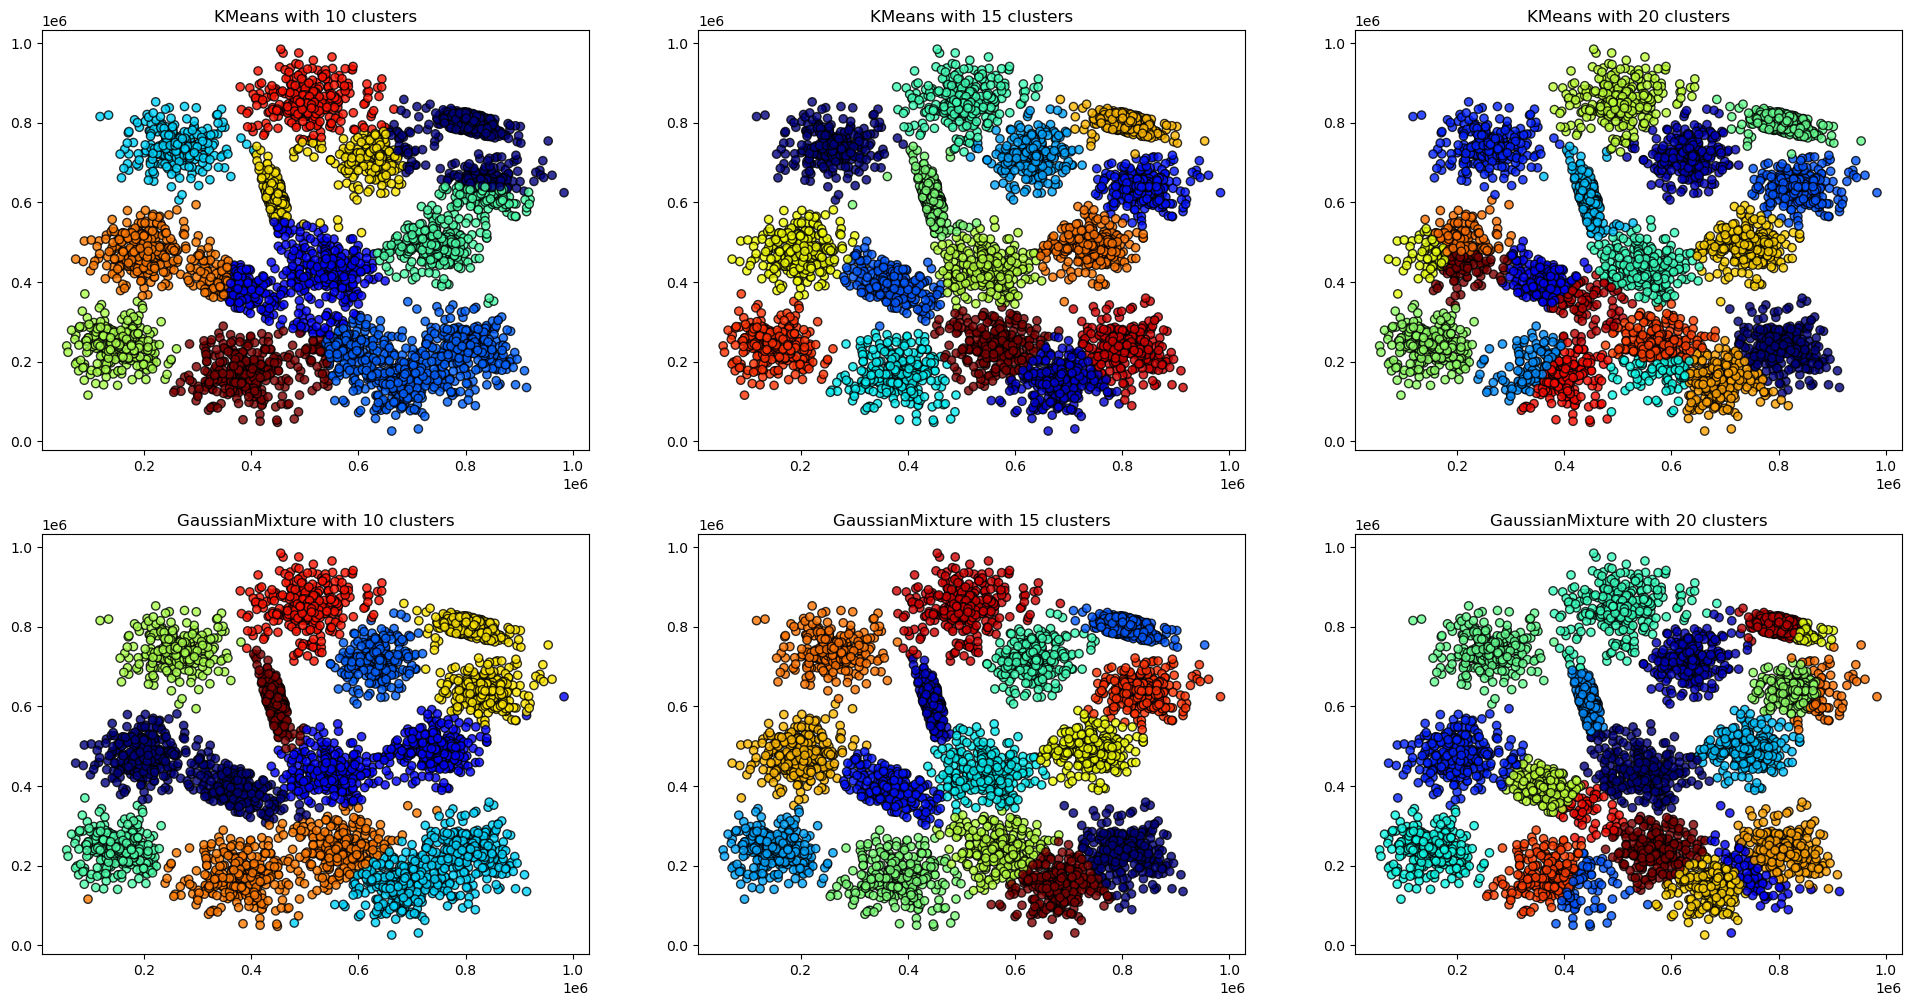

In [157]:
# Instantiate figure
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(24, 12))
clusters_numbers = [10, 15, 20]

# Iterate over cluster numbers do the prediction with best KMeans and GaussianMixture model and visualize the results
for i, n_clusters in enumerate(clusters_numbers):
    # Instantiate best models
    best_kmeans = KMeans(**best_config_dict[str(n_clusters) + 'kmeans'])
    best_gmm = GaussianMixture(**best_config_dict[str(n_clusters) + 'gmm'])

    # Fit best models
    pred_labels_kmeans = best_kmeans.fit_predict(points)
    pred_labels_gmm = best_gmm.fit_predict(points)

    # Visualize the results
    plot_results(ax=axes[0, i], clasterizator_name='KMeans', n_clusters=n_clusters, pred_labels=pred_labels_kmeans)
    plot_results(ax=axes[1, i], clasterizator_name='GaussianMixture', n_clusters=n_clusters, pred_labels=pred_labels_gmm)


## Task 5. Clustering [24 + 16 $\color{red}{\text{(Bonus)}}$ + 10 = 50 points]

In this task you will:

* implement **k-means** clustering;

* train a **Mixture of Gaussian** model by implementing the **EM** algorithm.

Let's generate some test data for you to test your implementation of the k-means and EM algorithm.

Note that we generate gaussian blobs with non-isotropic covariance matrices.

In [158]:
from scipy.stats import multivariate_normal

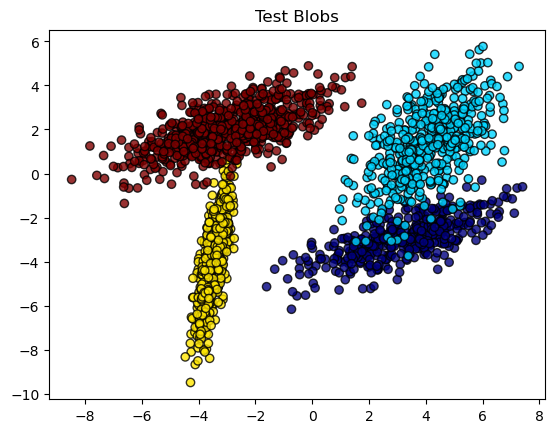

In [159]:
# generate samples of 4 different gaussians
rv1 = multivariate_normal.rvs([3.0, -3.], [[3.0, 1.2], [1.2, 0.9]], size=400, random_state=0)
rv2 = multivariate_normal.rvs([4.0, 1.25], [[1.45, 1.15], [1.15, 2.75]], size=500, random_state=0)
rv3 = multivariate_normal.rvs([-3.5, -4.0], [[0.1, 0.4], [0.4, 3.]], size=600, random_state=0)
rv4 = multivariate_normal.rvs([-3., 2.], [[3, 1.1], [1.1, 1]], size=700, random_state=0)

# concatenate the samples and create corresponding labels
X = np.concatenate([rv1, rv2, rv3, rv4], 0)
y = np.array([0]*400 + [1]*500 + [2]*600 + [3]*700)

# plot the test data

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm.jet, alpha=0.8, edgecolor='k')
plt.title("Test Blobs")
plt.show()

## Task 5.1. A modified K-Means [24 points]

You will need to implement a slightly modified **k-means** clustering algorithm and test it on the generated test data. Initialize the cluster centers from a Gaussian distribution with a mean 0 and covariance matrix $\sigma I$ where $\sigma = 0.2 \times max(|X|)$ if you flatten $X$; hence, $\sigma$ is a scalar. Morever, use L-infinity norm to assign data points to clusters instead of L2 norm; the L-infinity norm is given by $L_\infty = \max(|x|)$ for a vector $x$.

In [160]:
class KMeansCustom:
    def __init__(self, n_clusters, max_iter=100):
        """
        Initializes the k-means class object.

        Args:
            n_clusters: Number of clusters to use for clustering
            max_iter: Maximum number of iterations
            X: Data matrix of shape [num_data, num_features]
            y: Labels corresponding to X of size [num_data, 1]
            lambda_: Regularization hyper-parameter
        """
        # Initialize variables and enable availability for other methods of the class
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.cluster_centers_ = None
        self.labels_ = None

    def distortion(self, X):
        """
        Calculates the distortion function.

        Args:
            X: Matrix containing the training data of shape m x n, where m is the number of samples and n the dimensionality of samples

        Returns:
            distortion: Returns the distortion given the samples X
        """
        # Calculate distortion function
        distortion = 0
        for idx, sample in enumerate(X):
            normsquared = np.linalg.norm(sample - self.cluster_centers_[self.labels_[idx]])**2
            distortion += normsquared

        # Return distortion value
        return distortion

    def fit(self, X):
        """
        Fits the k-means algorithm to the data X.

        Args:
            X: Matrix containing the training data of shape m x n, where m is the number of samples and n the dimensionality of samples
        """
        # Initialize cluster centers
        dim = X.shape[1]
        samples_num = X.shape[0]
        sigma = 0.2 * np.max(X.flatten())
        mean = np.zeros(dim)
        covariance = sigma * np.eye(dim)
        self.cluster_centers_ = np.random.multivariate_normal(mean, covariance, size=self.n_clusters)

        # Initialize labels
        self.labels_ = np.zeros(samples_num).astype(int)

        # Iterate until convergence or maximum iterations
        tol = np.inf
        it = 1
        while tol > 0.001 and it <= self.max_iter:
            # Calculate prior distortion
            J_prior = self.distortion(X)

            # Assign samples to the nearest cluster
            for idx, sample in enumerate(X):
                diff = self.cluster_centers_ - sample
                norms = np.linalg.norm(diff, axis=1)
                self.labels_[idx] = np.argmin(norms)

            # Update cluster centers
            for idx in range(self.n_clusters):
                points_in_cluster = X[self.labels_ == idx]
                if len(points_in_cluster) > 0:  # Avoid empty cluster
                    self.cluster_centers_[idx] = np.mean(points_in_cluster, axis=0)
                else:  # Reinitialize empty cluster to a random point
                    self.cluster_centers_[idx] = np.random.multivariate_normal(mean, covariance, size=1)

            # Calculate distortion and tolerance
            J_posterior = self.distortion(X)
            tol = abs(J_prior - J_posterior)

            # Update index
            it += 1

        # Notify if maximum iterations reached
        if it > self.max_iter:
            print("Maximum allowed iterations reached!")

Let's test your implementation.

In [161]:
def plot_clusters(X, clasterizator):
    clasterizator.fit(X)
    
    plt.clf()
    
    plt.scatter(X[:, 0], X[:, 1], c=clasterizator.labels_, cmap=cm.jet)
    plt.scatter(clasterizator.cluster_centers_[:, 0], clasterizator.cluster_centers_[:, 1], c='r', marker='x')
    
    plt.title("Predicted clustering")
    plt.show()

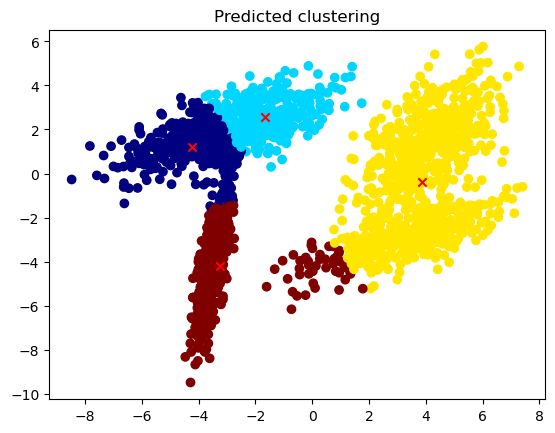

In [162]:
plot_clusters(X, KMeansCustom(n_clusters=4))

In [163]:
# Find best class number
k = np.arange(1, 15)
distor = np.zeros_like(k)
for idx, el in enumerate(k):
    current_kmeans = KMeansCustom(n_clusters=el)
    current_kmeans.fit(X)
    distor[idx] = current_kmeans.distortion(X)

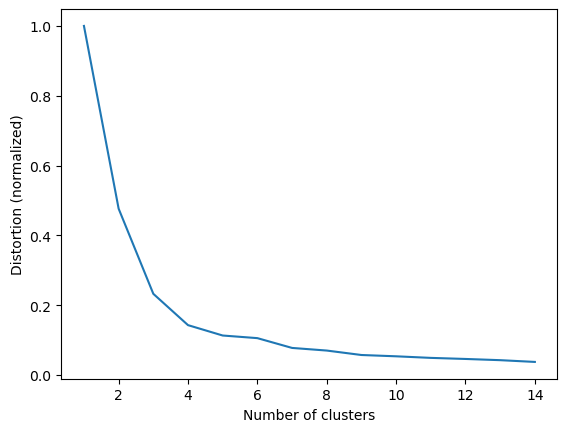

In [164]:
# Plot results
plt.plot(k, distor/np.max(distor))
plt.xlabel('Number of clusters')
plt.ylabel('Distortion (normalized)')
plt.show()

In the above plot of number of classes $k$ vs. the distortion function, one can clearly see that the elbow is located where we would expect it to be, at $k=4$.

## Task 5.2 $\color{red}{\text{(Bonus)}}$. Expectation Maximization [16 points]

In this task, you will need to implement the EM algorithm for the Mixture of Gaussian models.

* Let's implement the **E-step** of the EM algorithm.

**Hints**:

* Use `scipy.stats.multivariate_normal.pdf()` to compute the pdf of a gaussian with the current parameters.

* $\omega = \mathbb{P}(z = j | x; \mu, \sigma, \phi)$

In [165]:
from scipy.stats import multivariate_normal

The Gaussian Mixture Model repeats until convergence:
- **E-step**: Compute the posterior probabilities (soft assignments) of the latent variables by leveraging the Bayes theorem:  
    $$
    w^{(i)}_j = p(z^{(i)} = j | x^{(i)}; \phi, \mu, \Sigma) = \frac{p(x^{(i)} | z^{(i)} = j; \mu_j, \Sigma_j)p(z^{(i)} = j; \phi_j)}{\sum_{l=1}^k p(x^{(i)} | z^{(i)} = l; \mu_l, \Sigma_l)p(z^{(i)} = l; \phi_l)}.
    $$ 
    Note here, that the probabilities are given by:
    $$
    p(x^{(i)} | z^{(i)} = j; \mu_j, \Sigma_j) = \frac{1}{\sqrt{(2\pi)^n\det(\Sigma_j)}}\exp\left(-\frac{1}{2}(x^{(i)}-\mu_j)^\top\Sigma_j^{-1}(x^{(i)}-\mu_j)\right), \qquad p(z^{(i)} = j; \phi_j) = \phi_j,
    $$
    with $n$ given by the feature vector $x \in \mathbb{R}^n$ dimension. The soft assignment matrix $W \in \textrm{mat}(\mathbb{R}; m \times l)$ is given by 
    $$
    W = \begin{pmatrix}
    (w^{(1)})^\top \\
    \vdots \\
    (w^{(m)})^\top
    \end{pmatrix} = \begin{pmatrix}
    w_1^{(1)} & \dots & w_l^{(1)} \\
    \vdots & \vdots & \vdots \\
    w_1^{(m)} & \dots & w_l^{(m)}
    \end{pmatrix}.
    $$
 - **M-step**: Update the parameters using the soft assignments similar to using the indicator functions as in the supervised learning problem algorithms:  
    $$
    \phi_j = \frac{1}{m} \sum_{i=1}^m w^{(i)}_j, \quad \mu_j = \frac{\sum_{i=1}^m w^{(i)}_j x^{(i)}}{\sum_{i=1}^m w^{(i)}_j}, \quad \Sigma_j = \frac{\sum_{i=1}^m w^{(i)}_j (x^{(i)} - \mu_j)(x^{(i)} - \mu_j)^\top}{\sum_{i=1}^m w^{(i)}_j}.
    $$

In [166]:
def e_step(X, mu, sigma, phi, use_builtin=False):
    """
    Computes the E-step of a Gaussian Mixture Model.

    Args:
        X: Matrix of training samples (n_samples, n_features)
        mu: Vector of mean values for clusters (n_gaussians, n_features)
        sigma: List of covariance matrices for each cluster (n_gaussians, n_features, n_features)
        phi: Vector of probabilities of the latent variable z (n_gaussians,)
        use_builtin: Boolean variable, if builtin function multivariate_norma.pdf is used to compute Gaussian probabilities
    
    Returns:
        w: Matrix of soft assignments (n_samples, n_gaussians)
    """
    # Get the numbers n_samples, n_features and n_gaussians
    n_samples, n_features = X.shape
    n_gaussians = len(phi)
    
    # Initialize the soft assignments matrix (#rows = #samples, #columns = #clusters)
    w = np.zeros((n_samples, n_gaussians))
    
    # Compute the numerator of soft assignments for each cluster
    for j in range(n_gaussians):
        # Check, if use_builtin is False and compute Gaussian probabilities from scratch
        if use_builtin == False:
            # Compute differences in the exponent of Gaussian probability for cluster j
            diff = X - mu[j]

            # Compute inverse of covariance matrix for cluster j
            inv_sigma = np.linalg.inv(sigma[j])

            # Compute expression in exponent of Gaussian probability for cluster j
            exponent = -0.5 * np.sum(diff @ inv_sigma * diff, axis=1)

            # Compute normalizing factor for cluster j
            normalizer = np.sqrt((2 * np.pi)**n_features * np.linalg.det(sigma[j]))

            # Compute Gaussian probabilty for cluster j
            gaussian_prob = np.exp(exponent) / normalizer
        
        # Use builtin function to calculate Gaussian probabilities if use_builtin is True
        else:
            # Compute Gaussian probability for cluster j
            gaussian_prob = multivariate_normal.pdf(x=X, mean=mu[j], cov=sigma[j])
        
        # Compute column j of the soft assignment matrix
        w[:, j] = phi[j] * gaussian_prob
    
    # Normalize soft assignment matrix
    w =  w / np.sum(w, axis=1, keepdims=True)
    
    # Return soft assignment matrix
    return w

* Let's update all the model parameters as per the **M-step** of the EM.

In [167]:
def m_step(w, X, mu, sigma, phi, n_gaussians):
    """
    Computes the M-step of a Gaussian Mixture Model.

    Args:
        w: Matrix of soft assignments (n_samples, n_gaussians)
        X: Matrix of training samples (n_samples, n_features)
        mu: Vector of mean values for clusters (n_gaussians, n_features)
        sigma: List of covariance matrices for each cluster (n_gaussians, n_features, n_features)
        phi: Vector of probabilities of the latent variable z (n_gaussians,)
        n_gaussians: Number of clusters (Gaussians)
    
    Returns:
        phi: Updated vector of probabilities of the latent variable z (n_gaussians,)
        mu: Updated vector of mean values for clusters (n_gaussians, n_features)
        sigma: Updated list of covariance matrices for each cluster (n_gaussians, n_features, n_features)
    """
    # Calculate the probabilities phi
    new_phi = np.mean(w, axis=0)
    phi = new_phi

    # Calculate the mean value vector mu
    new_mu = np.zeros_like(mu)
    for j in range(n_gaussians):
        weighted_sum = np.sum(w[:, j][:, np.newaxis] * X, axis=0)
        normalizer = np.sum(w[:, j])
        new_mu[j] = weighted_sum / normalizer
    mu = new_mu

    # Calculate the covariance matrices sigma
    new_sigma = np.zeros_like(sigma)
    for j in range(n_gaussians):
        diff = X - mu[j]
        weighted_diff = w[:, j][:, np.newaxis] * diff
        new_sigma[j] = (weighted_diff.T @ diff) / np.sum(w[:, j])
    sigma = new_sigma

    # Return updated phi, mu and sigma
    return phi, mu, sigma

* Let's implement the **log-likelihood** of the data under the current model to check for convergence of the algorithm.

The function to maximize is the likelihood of the data $\{x^{(i)}\}_{i=1,\dots,m}$. Given the model parameters $\phi, \mu$ and $\Sigma$, that is to maximize the function 
$$
	f(\phi,\mu,\Sigma) = \sum_{i=1}^{m}p(x^{(i)};\phi,\mu,\Sigma)
$$
with respect to the model parameters $\phi$, $\mu$ and $\Sigma$. Using marginalization $p(x) = \int p(x|z)p(z)\,\mathrm{d}z$ for any random variables $x$ and $z$, furthermore leveraging te IID assumption aswell as taking the natural logarithm, the function to maximize $l(\phi,\mu,\Sigma)$ reads as 
$$
l(\phi,\mu,\Sigma) = \sum_{i=1}^m \ln \left( \sum_{j=1}^k p(x^{(i)} | z^{(i)} = j; \mu_j, \Sigma_j) p(z^{(i)} = j; \phi_j) \right).
$$
Maximizing $l(\phi,\mu,\Sigma)$ is equivalent to maximizing $f(\phi,\mu,\Sigma)$ from above.

In [168]:
def log_likelihood(X, mu, sigma, phi):
    """
    Compute the log-likelihood function.
    
    Parameters:
        X: Matrix of training samples (n_samples, n_features)
        mu: Vector of mean values for clusters (n_gaussians, n_features)
        sigma: List of covariance matrices for each cluster (n_gaussians, n_features, n_features)
        phi: Vector of probabilities of the latent variable z (n_gaussians,)
        
    Returns:
        log_likelihood_value: Scalar log-likelihood value
    """
    # Get the numbers n_samples, n_features and n_gaussians
    n_samples, n_features = X.shape
    n_gaussians = len(phi)
    
    # Initialize log-likelihood value
    log_likelihood_value = 0
    
    # Iterate over all samples
    for i in range(n_samples):
        # initialize likelihood value for a sample
        likelihood = 0

        # Interate over all clusters (Gaussians)
        for j in range(n_gaussians):
            # Compute p(x^(i) | z^(i)=j; mu_j, sigma_j)
            gaussian_prob = multivariate_normal.pdf(x=X[i], mean=mu[j], cov=sigma[j])

            # Compute weighted probability
            likelihood = likelihood + phi[j] * gaussian_prob

        # Add preliminary result to the total
        log_likelihood_value = log_likelihood_value + np.log(likelihood)
    
    # Return total likelihood
    return log_likelihood_value

Finally, fit the Mixture of Gaussians model using the **EM algorithm**.

**Hint**:

* $\phi$ is a vector of probabilities for the latent variables $z$ of shape `[n_gaussians]`

* $\mu$ is a marix of mean vectors of shape `[n_gaussians, num_features]` 

* $\sigma$ is a list of length `[n_gaussians]` of covariance matrices each of shape `[num_features, num_features]`

* $w$ is a vector of weights for the `[n_gaussians]` gaussians per example of shape `[n_gaussians, k]` (a result of the E-step)

In [169]:
def EM(X, n_gaussians, max_iter=20):
    """
    Implements the Gaussian Mixture Model expectation maximization algorithm.

    Args:
        X: Matrix of training samples (n_samples, n_features)
        n_gaussians: Number of clusters (Gaussians)
        max_iter: Maximum number of iterations, default is 20
    
    Returns:
        w: Matrix of soft assignments (n_samples, n_gaussians)
        mu: Vector of mean values for clusters (n_gaussians, n_features)
        sigma: List of covariance matrices for each cluster (n_gaussians, n_features, n_features)
        phi: Vector of probabilities of the latent variable z (n_gaussians,)
    """
    # Initialization
    n_samples, n_features = X.shape
    mu = None
    sigma = [np.eye(X.shape[1]) for i in range(n_gaussians)]
    phi = np.ones([n_gaussians,]) / n_gaussians
    w = np.zeros((n_samples, n_gaussians))
    
    # Log-likelihood 
    log_likelihood_previous = -np.inf
    
    # Initialize cluster centers using k-means
    kmeans = KMeans(n_clusters=n_gaussians, random_state=42, n_init=10).fit(X)
    mu = kmeans.cluster_centers_

    # Define tolerance and difference value of old and new log-likelihood
    tol = 1e-2
    diff = np.inf
    ite = int(0)

    # Loop until convergence or max_iter reached
    while ite <= max_iter and diff >= tol:
        # Iteration counter update
        ite = ite + 1

        # E-step
        w = e_step(X, mu, sigma, phi)
            
        # M-step
        phi, mu, sigma = m_step(w, X, mu, sigma, phi, n_gaussians)
        
        # Calculate log-likelihood and difference
        log_likelihood_current = log_likelihood(X, mu, sigma, phi)
        diff = log_likelihood_current - log_likelihood_previous
        
        # Check convergence
        if diff > 0:
            log_likelihood_previous = log_likelihood_current
        else:
            print("There seems to be a convergence issue!")

    # Return values
    return phi, mu, sigma, w

Let's test your implementation.

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


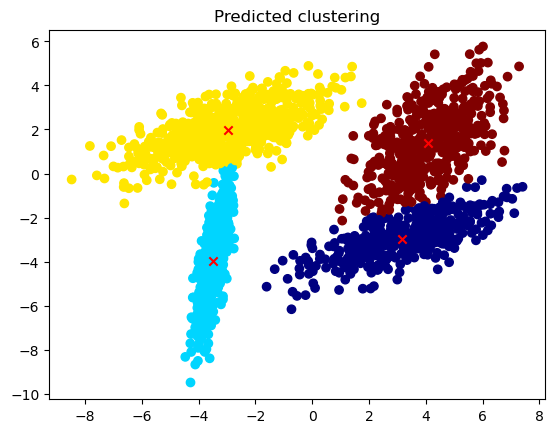

In [170]:
phi, mu, sigma, w = EM(X, n_gaussians=4)

plt.clf()
plt.scatter(X[:, 0], X[:, 1], c=np.argmax(w, 1), cmap=cm.jet)
plt.scatter(mu[:, 0], mu[:, 1], c='r', marker='x')
plt.title("Predicted clustering")
plt.show()

## Task 5.3.1 K-Means for Image Compression [6 points]

You will now use **k-means to cluster pixel values of an image** and use the cluster assignments as a way to quantize/compress the color-space of the image.

Feel free to test the algorithm on your own images and with different number of clusters.
* Let's implement the KMeans function for our images which applies K-Means clustering in pixel space

In [217]:
def kmeans_colors(image, n_colors, clasterizator):
    """
    Apply K-Means clustering to compress the colors in an image.

    Args:
        image: The input image as a 3D numpy array (H, W, C)
        n_colors: The number of colors (clusters) to reduce the image to
        clasterizator: The clustering algorithm to use (e.g., KMeans)
    Returns:
        image_quantized: The quantized image with `n_colors` clusters
    """
    # Reshape image into (N, 3) where N = H * W, and 3 is RGB/HSV channels
    H, W, C = image.shape
    pixels = image.reshape(-1, C)
    
    # Apply K-Means
    kmeans = clasterizator(n_clusters=n_colors, random_state=42, n_init=10)
    kmeans.fit(pixels)
    
    # Replace each pixel with its cluster center
    quantized_pixels = kmeans.cluster_centers_[kmeans.labels_]
    
    # Reshape back to original image dimensions
    image_quantized = quantized_pixels.reshape(H, W, C).astype(np.uint8)

    # Return compressed image
    return image_quantized

## Task 5.3.2 K-Means for Image Compression with Different Number of Pixels [4 points]

Let's test your implementation and try to quantize the given image into 3, 6, 9 and 12 colors in HSV color space. For each quantization case:

* Take the image which is already in HSV color space and then perform the quantization

* Calculate mean squared error between the original image and the quantized image.

* Convert the quantized image to RGB colorspace for visualization

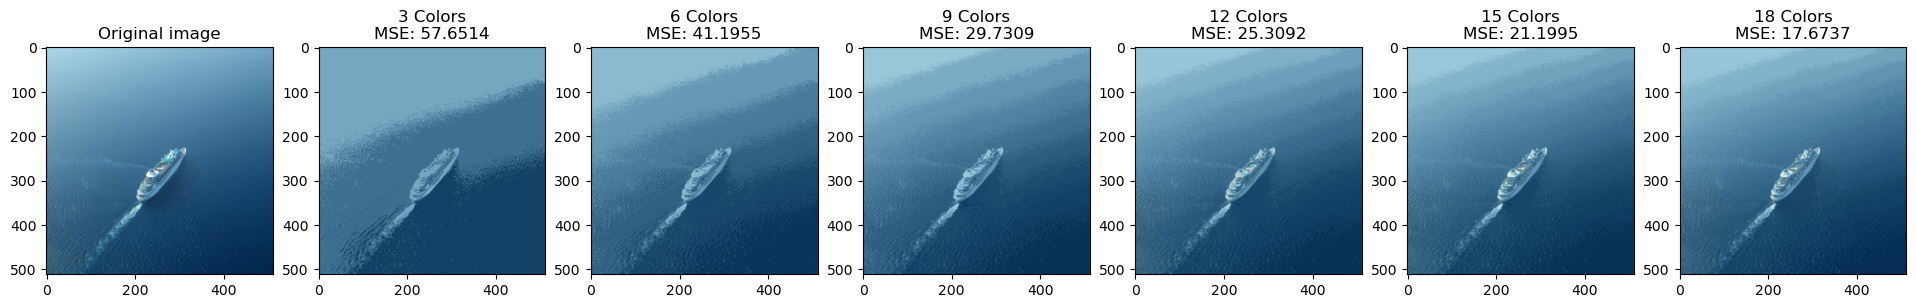

In [ ]:
from PIL import Image
from sklearn.metrics import mean_squared_error

# Load and preprocess the image
image = Image.open('data/ship_image.jpg').resize((512, 512))
image_rgb = np.array(image)
image_hsv = np.array(image.convert('HSV'))

# Define the grid
fig, axes = plt.subplots(ncols=7, nrows=1, figsize=(24, 12))
axes[0].imshow(image)
axes[0].set_title("Original image")

# Define array for losses
image_losses = []

# Apply K-Means with different numbers of clusters
for i, n_colors in enumerate([3, 6, 9, 12, 15, 18]):
    # Quantize the image using KMeans
    image_quantized_hsv = kmeans_colors(image_hsv, n_colors, KMeans)
    
    # Calculate MSE between original and quantized image (in HSV space)
    mse = mean_squared_error(image_hsv.flatten(), image_quantized_hsv.flatten())
    image_losses.append(mse)
    
    # Convert quantized image back to RGB for visualization
    image_quantized_rgb = Image.fromarray(image_quantized_hsv, 'HSV').convert('RGB')
    
    # Plot the quantized image
    axes[i + 1].imshow(image_quantized_rgb)
    axes[i + 1].set_title(f"{n_colors} Colors\nMSE: {mse:.4f}")

# Show figure
plt.show()

Let's draw the plot of the MSE vs number colors 

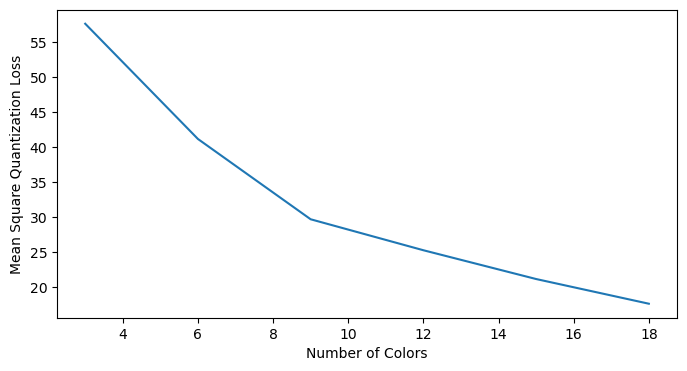

In [192]:
plt.figure(figsize=(8, 4))
plt.plot([3*(i+1) for i in range(6)], image_losses)
plt.xlabel('Number of Colors')
plt.ylabel('Mean Square Quantization Loss')
plt.show()

Looking at this plot, one can see that the elbow of the k-means algorithm seems to be at a cluster number (colors number) of nine. Hence, an ideal compression of the image is achieved by compressing it to only nine colors. With respect to the results, the compressed image with nine colors looks quite similar to the original picture, with exception of the color gradient in the water, which is clearly divided into several color classes in the compresed image, such that it is penetrantly visible by eye.